The objective of this notebook is to preprocess the dataset 

## Libraries

In [28]:
import pandas as pd 
import matplotlib.pyplot as plt
import re
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer


[nltk_data] Downloading package punkt to /home/maldu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/maldu/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/maldu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
df = pd.read_csv("../data/bronze/spam.csv")


### Change data types

In [9]:
df['Category'] = df['Category'].map({"ham": 0, "spam": 1}).astype(int)
df['Message'] = df['Message'].astype(str)

### Duplicated rows analysis

In [14]:
total_duplicates = df.duplicated().sum()
print(f"Total duplicated rows: {total_duplicates}")


Total duplicated rows: 415


In [ ]:
duplicates_summary = df[df.duplicated(keep=False)].groupby(df.columns.tolist()).size().reset_index(name='count')
duplicates_summary


,Category,Message,count
0,0,1) Go to write msg 2) Put on Dictionary mode 3...,3
1,0,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
2,0,A Boy loved a gal. He propsd bt she didnt mind...,2
3,0,"A bit of Ur smile is my hppnss, a drop of Ur t...",2
4,0,"A boy was late 2 home. His father: ""POWER OF F...",2
...,...,...,...
284,1,You have an important customer service announc...,2
285,1,You have won a Nokia 7250i. This is what you g...,3
286,1,You won't believe it but it's true. It's Incre...,2
287,1,You've won tkts to the EURO2004 CUP FINAL or £...,2


In [24]:
duplicates_with_diff_category = (
    df.groupby(df.columns.difference(['Category']).tolist())
    .agg({'Category': 'nunique'})
    .reset_index()
)

# Filtrar grupos donde la columna Category tenga más de un valor único
conflicting_rows = duplicates_with_diff_category[duplicates_with_diff_category['Category'] > 1]

print(conflicting_rows)


Empty DataFrame
Columns: [Message, Category]
Index: []


In [26]:
conflicting_indices = df[df.duplicated(subset=df.columns.difference(['Category']), keep=False)]
conflicting_indices.sort_values(by=df.columns.difference(['Category']).tolist())


,Category,Message
2124,1,#ERROR!
717,1,#ERROR!
505,1,#ERROR!
2163,0,1) Go to write msg 2) Put on Dictionary mode 3...
1373,0,1) Go to write msg 2) Put on Dictionary mode 3...
...,...,...
1381,0,i dnt wnt to tlk wid u
4004,0,somewhere out there beneath the pale moon ligh...
1412,0,somewhere out there beneath the pale moon ligh...
2389,0,wiskey Brandy Rum Gin Beer Vodka Scotch Shampa...


In [ ]:
duplicates_summary


,Category,Message,count
0,0,1) Go to write msg 2) Put on Dictionary mode 3...,3
1,0,7 wonders in My WORLD 7th You 6th Ur style 5th...,4
2,0,A Boy loved a gal. He propsd bt she didnt mind...,2
3,0,"A bit of Ur smile is my hppnss, a drop of Ur t...",2
4,0,"A boy was late 2 home. His father: ""POWER OF F...",2
...,...,...,...
284,1,You have an important customer service announc...,2
285,1,You have won a Nokia 7250i. This is what you g...,3
286,1,You won't believe it but it's true. It's Incre...,2
287,1,You've won tkts to the EURO2004 CUP FINAL or £...,2


In [19]:
percent_duplicates = (total_duplicates / len(df)) * 100
print(f"Percentage of duplicated: {percent_duplicates:.2f}%")


Percentage of duplicated: 7.45%


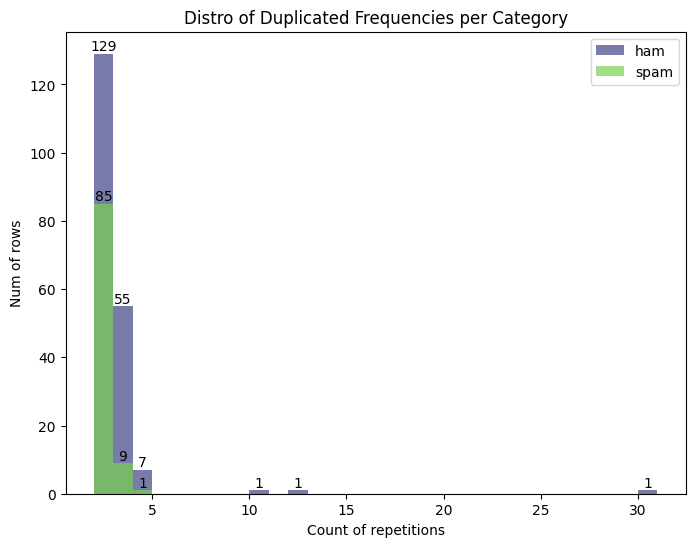

In [36]:
category_0 = duplicates_summary[duplicates_summary['Category'] == 0]
category_1 = duplicates_summary[duplicates_summary['Category'] == 1]

bins = range(min(duplicates_summary['count']), max(duplicates_summary['count']) + 2, 1)

cmap = plt.cm.viridis
color_0 = cmap(0.2) 
color_1 = cmap(0.8)  

plt.figure(figsize=(8, 6))
n_0, bins_0, patches_0 = plt.hist(category_0['count'], bins=bins, color=color_0, alpha=0.7, label='ham')
n_1, bins_1, patches_1 = plt.hist(category_1['count'], bins=bins, color=color_1, alpha=0.7, label='spam')

for i in range(len(patches_0)):
    height = patches_0[i].get_height()  
    if height > 0: 
        plt.text(patches_0[i].get_x() + patches_0[i].get_width() / 2, height, str(int(height)),
                 ha='center', va='bottom', fontsize=10, color='black')

for i in range(len(patches_1)):
    height = patches_1[i].get_height()  
    if height > 0:  
        plt.text(patches_1[i].get_x() + patches_1[i].get_width() / 2, height, str(int(height)),
                 ha='center', va='bottom', fontsize=10, color='black')

plt.title("Distro of Duplicated Frequencies per Category")
plt.xlabel("Count of repetitions")
plt.ylabel("Num of rows")
plt.legend()
plt.show()

Note:

It seems that duplicated e-mails are less likely to be repeated. I didn't expect that...
I will delete them for now

In [5]:
df.drop_duplicates(inplace=True)

In [6]:
def clean_text(text):
    special_replacements = {
        r"£": "pound",
        r"\$": "dollar",
        r"\€": "euro",
        r"%": "percentage", 
        r"ì": "i",
        r"ü": "you",
        }
    
    emoticon_pattern = re.compile(r"""
    [:;=Xx]           
    [-~]?             
    [\)\]\(\[dDpP/]   
    """, re.VERBOSE)
    
    for pattern, replacement in special_replacements.items():
        text = re.sub(pattern, replacement, text)
    text = re.sub(emoticon_pattern, 'emoji', text)
    text = text.lower()
    text = re.sub('<[^<>]+>', ' ', text)
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub('[0-9]+', 'number', text)
    text = re.sub('[^\s]+@[^\s]+', 'emailaddr', text)
    text = text.translate(str.maketrans('', '', punctuation))
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
df['Message']=df['Message'].apply(clean_text)
df['Message'] = df['Message'].apply(word_tokenize)
df['Message'] = df['Message'].apply(lambda x: [word for word in x if word not in stop_words])

lemmatizer=WordNetLemmatizer()
def lem_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

df['Message'] = df['Message'].apply(lem_tokens)
df = df[df['Message'].str.strip().astype(bool)]

In [8]:
df.to_csv("../data/silver/df_preprocessed.csv", index= False)
df

,Category,Message
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, number, wkly, comp, win, fa, cup..."
3,0,"[u, dun, say, early, hor, u, c, already, say]"
4,0,"[nah, dont, think, go, usf, life, around, though]"
...,...,...
5567,1,"[numbernd, time, tried, number, contact, u, u,..."
5568,0,"[b, going, esplanade, fr, home]"
5569,0,"[pity, mood, soany, suggestion]"
5570,0,"[guy, bitching, acted, like, id, interested, b..."
